<a href="https://colab.research.google.com/github/djliden/deep_learning_practice/blob/main/notebooks/ch6_2_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Regression
In this section, we consider the problem of *image regression*. In such a situation, the independent variable is an image and the dependent variable is one or more floating point numbers. JH emphasizes that this is *not* a fundamentally different application; it is, instead, another CNN on top of the data block API.

In particular, we're training a *key point model*. This is a model that finds a specific location represented in an image. In this case, we'll be looking for the center of a person's face. Practically speaking, this means we're looking for two numbers: the row and the column in the grid of pixels.

## The Data
We will be using the Biwi Kinect Head Pose dataset. It contains 24 directories numbered 1-24 corresponding to different people photographed.

In [2]:
from fastai.vision.all import *

path = untar_data(URLs.BIWI_HEAD_POSE)
path.ls()

(#50) [Path('/root/.fastai/data/biwi_head_pose/11.obj'),Path('/root/.fastai/data/biwi_head_pose/14.obj'),Path('/root/.fastai/data/biwi_head_pose/24'),Path('/root/.fastai/data/biwi_head_pose/02'),Path('/root/.fastai/data/biwi_head_pose/18.obj'),Path('/root/.fastai/data/biwi_head_pose/19'),Path('/root/.fastai/data/biwi_head_pose/22.obj'),Path('/root/.fastai/data/biwi_head_pose/04'),Path('/root/.fastai/data/biwi_head_pose/14'),Path('/root/.fastai/data/biwi_head_pose/17.obj')...]

In [3]:
# Exploring the subdirectory
(path/'01').ls()

(#1000) [Path('/root/.fastai/data/biwi_head_pose/01/frame_00052_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00235_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00058_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00060_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00277_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00497_rgb.jpg'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00042_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00180_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00241_pose.txt'),Path('/root/.fastai/data/biwi_head_pose/01/frame_00156_rgb.jpg')...]

There are 1000 frames within the subdir. We have "...pose.txt" and "...rgp.jpg" files. We need to write a file to associate the pose file with their corresponding image files. The pose files specify the location of the center of the head.

In [4]:
img_files = get_image_files(path)
def img2pose(x): return Path(f'{str(x)[:-7]}pose.txt')
img2pose(img_files[0])

Path('/root/.fastai/data/biwi_head_pose/24/frame_00052_pose.txt')

In [5]:
im = PILImage.create(img_files[0])
im.shape

(480, 640)

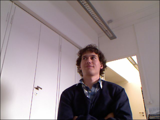

In [6]:
im.to_thumb(160)

We aren't currently going to go into the process of extracting the head center location from the pose files. The code for doing so is:

In [7]:
cal = np.genfromtxt(path/'01'/'rgb.cal', skip_footer=6)
def get_ctr(f):
    ctr = np.genfromtxt(img2pose(f), skip_header=3)
    c1 = ctr[0] * cal[0][0]/ctr[2] + cal[0][2]
    c2 = ctr[1] * cal[1][1]/ctr[2] + cal[1][2]
    return tensor([c1,c2])


In [8]:
get_ctr(img_files[0])

tensor([378.4036, 240.4584])

## Setting Up the Splitter

This is the first example we've seen where we need to be particularly thoughtful about the splitter. We don't just want random images. Why? Because there are groups of images for each of a few different people. We want the model to be able to generalize to different people, not just different poses for the same people.

## The DataBlock

In [9]:
biwi = DataBlock(
    blocks = (ImageBlock, PointBlock), # PointBlock for coordinates
    get_items = get_image_files,
    get_y = get_ctr,
    splitter = FuncSplitter(lambda o: o.parent.name=='13'), #picking person 13 as validation?
    batch_tfms = [*aug_transforms(size=(240,320)),
                 Normalize.from_stats(*imagenet_stats)]
)

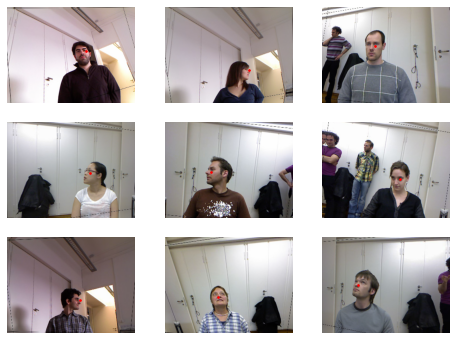

In [10]:
dls = biwi.dataloaders(path)
dls.show_batch(max_n=9, figsize=(8,6))

In [11]:
xb, yb = dls.one_batch()
xb.shape, yb.shape

(torch.Size([64, 3, 240, 320]), torch.Size([64, 1, 2]))

Why these sizes?
- A batch size of 64 explains the first dimension in both cases
- 3 colors
- 240 x 320 dimension
- why 2 for the final y part? I'd have assumed (x,y). A: 1 row, two columns coordinate.

## Training the Model

In [12]:
learn = cnn_learner(dls, resnet18, y_range=(-1,1))

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


Behind the scenes, `y_range` rescales the targets using a `sigmoid` function:

```
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo
```

Why does this dow what it claims to do? we multiply by `(hi-lo)` to get the correct magnitude -- to "stretch" the sigmoid function as needed. Then we add `lo` to translate the function to the correct "starting point."

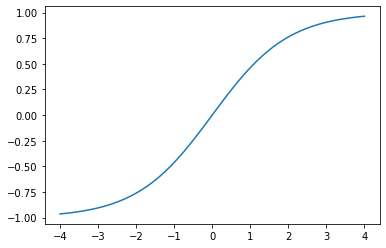

In [14]:
def plot_function(f, tx=None, ty=None, title=None, min=-2, max=2, figsize=(6,4)):
    x = torch.linspace(min,max)
    fig,ax = plt.subplots(figsize=figsize)
    ax.plot(x,f(x))
    if tx is not None: ax.set_xlabel(tx)
    if ty is not None: ax.set_ylabel(ty)
    if title is not None: ax.set_title(title)
        
def sigmoid_range(x, lo, hi): return torch.sigmoid(x) * (hi-lo) + lo

plot_function(partial(sigmoid_range,lo=-1,hi=1),min=-4,max=4)

In [15]:
# What is the default loss function?

dls.loss_func

FlattenedLoss of MSELoss()

SuggestedLRs(lr_min=0.005754399299621582, lr_steep=0.03981071710586548)

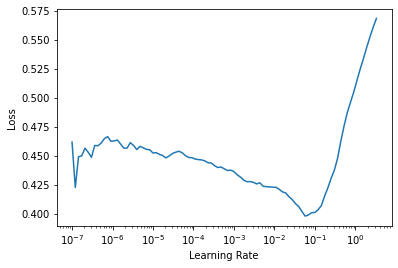

In [16]:
learn.lr_find()

In [17]:
lr = 2e-2
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,time
0,0.046508,0.017784,01:52
1,0.007049,0.002718,01:52
2,0.002899,0.000453,01:52
3,0.001992,0.000363,01:53
4,0.001529,0.000228,01:53


In [19]:
math.sqrt(.0002)

0.01414213562373095

So our average coordinate prediction error is approx. .014.

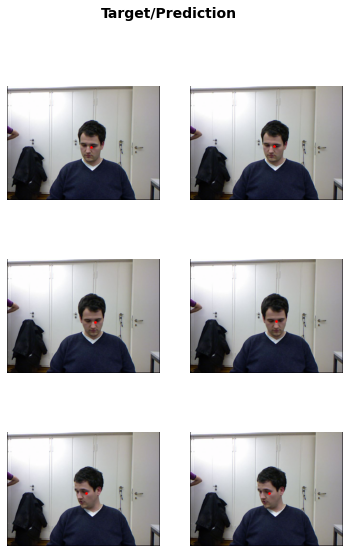

In [22]:
learn.show_results()